In [1]:
# Config and imports

import pypsa
import logging
import atlite
import time
import warnings
import geopandas as gpd
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from plotly import express as px
from plotly import graph_objects as go
from datetime import datetime
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.gridspec import GridSpec
import ipywidgets as widgets
from atlite.gis import shape_availability, ExclusionContainer
from lib.optimize import create_and_store_optimize
from lib.network import create_and_store_network
from lib.costs import create_and_store_costs
from lib.cutout import create_and_store_cutout
from lib.availability import create_and_store_availability
from lib.demand import create_and_store_demand
logging.basicConfig(level=logging.INFO)


# Configuration specified in /prototypes/configs
CONFIG_NAME = "single"
# In the config file, we have a secnarios configuration that is used to create files per scenario. In this notebook, we use the following scenario
SCENARIO = "weather=2023,costs=2030,demand=2023,load-target=19,network-nuclear=True,network-h2=True,network-biogas=Stor,network-onwind-limit=None,network-offwind-limit=None,geography=14"
# Check the config file, or print all possible options with following code:
# %run scenarios.py "list" "$CONFIG_NAME" False
%run scenarios.py "validate" "$CONFIG_NAME" False "$SCENARIO"

with open(f"../data/result/{SCENARIO}/config.json", "r") as f:
    CONFIG = json.load(f)


In [5]:
# Setting variables based on config
DATA_PATH=CONFIG["scenario"]["data-path"]
WEATHER_START=CONFIG["scenario"]["weather_start"]
WEATHER_END=CONFIG["scenario"]["weather_end"]
LAN_CODE = CONFIG["scenario"]["geography_lan_code"]
KOM_CODE = CONFIG["scenario"]["geography_kom_code"]

## Wind turbines
WIND_TURBINE = CONFIG["onwind_turbine"]
WIND_TURBINE_OFFSHORE = CONFIG["offwind_turbine"]

## Cutout / selection
CUTOUT = atlite.Cutout(f"../{DATA_PATH}/cutout.nc")
SELECTION = gpd.read_file(f"../{DATA_PATH}/selection.shp")
EEZ = gpd.read_file(f"../{DATA_PATH}/eez.shp")
INDEX = pd.to_datetime(pd.read_csv(f"../{DATA_PATH}/time_index.csv")["0"])

# Cutout / availablity
AVAIL_SOLAR = xr.open_dataarray(f"../{DATA_PATH}/avail_solar.nc")
AVAIL_ONWIND = xr.open_dataarray(f"../{DATA_PATH}/avail_onwind.nc")
AVAIL_OFFWIND = xr.open_dataarray(f"../{DATA_PATH}/avail_offwind.nc")

AVAIL_CAPACITY_SOLAR = xr.open_dataarray(f"../{DATA_PATH}/avail_capacity_solar.nc")
AVAIL_CAPACITY_ONWIND = xr.open_dataarray(f"../{DATA_PATH}/avail_capacity_onwind.nc")
AVAIL_CAPACITY_OFFWIND = xr.open_dataarray(f"../{DATA_PATH}/avail_capacity_offwind.nc")

DEMAND = pd.read_csv(f"../{DATA_PATH}/demand.csv", index_col=0, parse_dates=[0])

NETWORK = pypsa.Network()
NETWORK.import_from_netcdf(f"../{DATA_PATH}/network.nc")

STATISTICS = pd.read_pickle(f"../{DATA_PATH}/statistics.pkl")

parameters = pd.read_csv("../data/assumptions.csv")
parameters.set_index(['technology', 'parameter'], inplace=True)


INFO:pypsa.io:Imported network network.nc has buses, carriers, generators, links, loads, stores


In [6]:
## OVERRIDING VARIABLES?
#CONFIG["demand-target"] = 0.05
# And then, to update any step, just uncomment and run
#create_and_store_costs(CONFIG)
#create_and_store_cutout(CONFIG)
#create_and_store_availability(CONFIG)
#create_and_store_demand(CONFIG)
#create_and_store_network(CONFIG)
#create_and_store_optimize(CONFIG)

STATISTICS


Optimal Capacity  Installed Capacity  Capacity Factor  \
Generator backstop       1344.542740                 0.0         0.007308   
          biogas         1000.000000                 0.0         0.082278   
          nuclear         600.000000                 0.0         0.387198   
          offwind         660.000000                 0.0         0.124932   
          onwind         5940.000000                 0.0         0.290509   
          solar          2847.000000                 0.0         0.128958   
Link      AC             1200.000000                 0.0         0.119270   
          biogas         1000.000000                 0.0         0.082278   
          h2             3382.500000                 0.0         0.205318   
          li-ion         1650.447436                 0.0         0.103498   
          mixedgas       2182.500000                 0.0         0.155145   
          nuclear         600.000000                 0.0         0.387198   
          offwind        1655.646959                 0.0         0.049802   
          onwind         6465.718329                 0.0         0.266888   
          solar          4016.197656                 0.0         0.091416   
Load      -                 0.000000                 0.0              NaN   
Store     h2           146776.468259                 0.0         0.464803   
          li-ion         4560.621484                 0.0         0.393298   

                        Dispatch  Transmission    Withdrawal        Supply  \
Generator backstop  8.607527e+04  0.000000e+00  0.000000e+00  8.607527e+04   
          biogas    7.207511e+05  0.000000e+00  0.000000e+00  7.207511e+05   
          nuclear   2.035115e+06  0.000000e+00  0.000000e+00  2.035115e+06   
          offwind   7.223089e+05  0.000000e+00  0.000000e+00  7.223089e+05   
          onwind    1.511647e+07  0.000000e+00  0.000000e+00  1.511647e+07   
          solar     3.216175e+06  0.000000e+00  0.000000e+00  3.216175e+06   
Link      AC        0.000000e+00  0.000000e+00  1.253764e+06  1.253764e+06   
          biogas    0.000000e+00  7.207511e+05  7.207511e+05  7.207511e+05   
          h2       -1.592899e+06  3.838310e+06  6.083722e+06  4.490823e+06   
          li-ion   -5.445545e+04  6.813347e+05  1.496372e+06  1.441917e+06   
          mixedgas -1.248279e+06  2.966163e+06  2.966163e+06  1.717884e+06   
          nuclear   0.000000e+00  0.000000e+00  2.035115e+06  2.035115e+06   
          offwind   0.000000e+00  5.609845e+05  7.223089e+05  7.223089e+05   
          onwind    0.000000e+00  1.282530e+07  1.511647e+07  1.511647e+07   
          solar     0.000000e+00  2.565565e+06  3.216175e+06  3.216175e+06   
Load      -        -1.900000e+07  0.000000e+00  1.900000e+07  0.000000e+00   
Store     h2        4.365575e-11  0.000000e+00  2.245412e+06  2.245412e+06   
          li-ion   -1.256912e+03  0.000000e+00  6.535133e+05  6.522564e+05   

                     Curtailment  Capital Expenditure  \
Generator backstop  0.000000e+00         0.000000e+00   
          biogas    0.000000e+00         0.000000e+00   
          nuclear   0.000000e+00         1.830407e+09   
          offwind   1.804175e+06         1.063838e+09   
          onwind    4.799227e+06         5.551670e+09   
          solar     9.717165e-07         9.215913e+08   
Link      AC        0.000000e+00         0.000000e+00   
          biogas    0.000000e+00         0.000000e+00   
          h2        0.000000e+00         7.381627e+08   
          li-ion    0.000000e+00         1.605104e+08   
          mixedgas  0.000000e+00         2.081021e+09   
          nuclear   0.000000e+00         0.000000e+00   
          offwind   0.000000e+00         0.000000e+00   
          onwind    0.000000e+00         0.000000e+00   
          solar     0.000000e+00         0.000000e+00   
Load      -         0.000000e+00         0.000000e+00   
Store     h2        0.000000e+00         9.768003e+08   
          li-ion    0.000000e+00         6.1306

In [5]:
# Exclude land use per solar/wind

# Source: https://www.uts.edu.au/oecm/renewable-resource-mapping
# (Classification mapping: https://collections.sentinel-hub.com/corine-land-cover/readme.html)
# With the exception of "41; Water bodies"

# Land-cover classes NOT included for solar areas:
EXCLUDED_SOLAR = [1,4,5,6,7,9,10,11,23,24,25,27,30,33,34,35,36,37,38,39,40,41,42,43,44] # 1.1.1,1.2.2,1.2.3,1.2.4,1.3.1,1.3.3,1.4.1,1.4.2,3.1.1,3.1.2,3.1.3,3.2.2,3.3.1,3.3.4,3.3.5,4.1.1,4.1.2,4.2.1,4.2.2,4.2.3,5.1.1,5.1.2,5.2.1,5.2.2,5.2.3
# Land-cover classes NOT included for wind energy areas:
EXCLUDED_WIND_NON_OCEAN = [1,2,3,4,5,6,7,9,10,11,15,16,17,23,24,25,27,30,31,33,34,35,36,37,38,39,40,41,42,43,44] # 1.1.1,1.1.2,1.2.1,1.2.2,1.2.3,1.2.4,1.3.1,1.3.3,1.4.1,1.4.2,2.2.1,2.2.2,2.2.3,3.1.1,3.1.2,3.1.3,3.2.2,3.3.1,3.3.2,3.3.4,3.3.5,4.1.1,4.1.2,4.2.1,4.2.2,4.2.3,5.1.1,5.1.2,5.2.1,5.2.2,5.2.3
INCLUDED_WIND_OCEAN = [44, 41] # 5.2.3, 5.1.2


CORINE = "../data/geo/corine.tif"
solar_excluder = ExclusionContainer()
onwind_excluder = ExclusionContainer()
offwind_excluder = ExclusionContainer()

solar_excluder.add_raster(CORINE, codes=EXCLUDED_SOLAR)
onwind_excluder.add_raster(CORINE, codes=EXCLUDED_WIND_NON_OCEAN)
offwind_excluder.add_raster(CORINE, codes=INCLUDED_WIND_OCEAN, invert=True)

solar_avail = CUTOUT.availabilitymatrix(SELECTION, solar_excluder)
onwind_avail = CUTOUT.availabilitymatrix(SELECTION, onwind_excluder)
offwind_avail = CUTOUT.availabilitymatrix(SELECTION, offwind_excluder)

Compute availability matrix: 100%|██████████| 1/1 [00:00<00:00,  3.72 gridcells/s]


KeyError: "None of [Index(['Gas turbine'], dtype='object', name='Link')] are in the [index]"

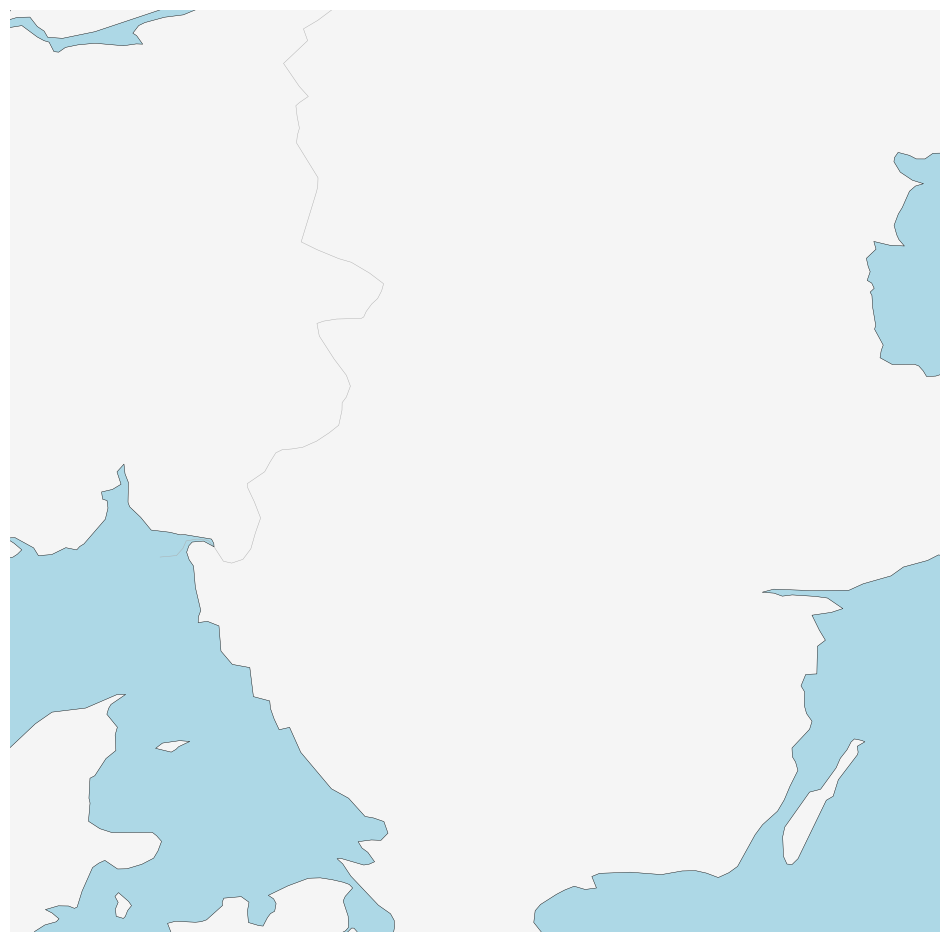

In [20]:
# Plot the dashboard
bus_colors = ["black", "yellow", "blue", "green", "lightblue", "red", "red", "red", "red"]
network = NETWORK

## Parameters
window_size=56 # Rolling average window size for charts

## Create solar availability map widget
solar_map = widgets.Output()
with solar_map:
    solar_excluder.plot_shape_availability(SELECTION, show_kwargs = { "cmap": "Reds" })
    plt.show()

## Create onwind availability map widget
onwind_map = widgets.Output()
with onwind_map:
    onwind_excluder.plot_shape_availability(SELECTION, show_kwargs = { "cmap": "Greens" })
    plt.show()

## Create offwind availability map widget
offwind_map = widgets.Output()
with offwind_map:
    offwind_excluder.plot_shape_availability(SELECTION, show_kwargs = { "cmap": "Blues" })
    plt.show()

## Create solar capacity factor line chart widget
solar_capacity_line_chart = widgets.Output()
with solar_capacity_line_chart:
    fig, ax = plt.subplots(figsize=(12, 4))
    AVAIL_CAPACITY_SOLAR.plot(ax=ax, color="Red", alpha=0.2)
    AVAIL_CAPACITY_SOLAR.rolling(time=window_size, center=True).mean().plot(ax=ax, color="Red")
    ax.set_ylabel("Capacity factor")
    ax.set_xlabel('')
    plt.show()

## Create onwind capacity factor line chart widget
onwind_capacity_line_chart = widgets.Output()
with onwind_capacity_line_chart:
    fig, ax = plt.subplots(figsize=(12, 4))
    AVAIL_CAPACITY_ONWIND.plot(ax=ax, color="Green", alpha=0.2)
    AVAIL_CAPACITY_ONWIND.rolling(time=window_size, center=True).mean().plot(ax=ax, color="Green")
    ax.set_ylabel("Capacity factor")
    ax.set_xlabel('')
    plt.show()

## Create offwind capacity factor line chart widget
offwind_capacity_line_chart = widgets.Output()
with offwind_capacity_line_chart:
    fig, ax = plt.subplots(figsize=(12, 4))
    AVAIL_CAPACITY_OFFWIND.plot(ax=ax, color="Blue", alpha=0.2)
    AVAIL_CAPACITY_OFFWIND.rolling(time=window_size, center=True).mean().plot(ax=ax, color="Blue")
    ax.set_ylabel("Capacity factor")
    ax.set_xlabel('')
    plt.show()

## Create target load line chart widget
load_line_chart = widgets.Output()
with load_line_chart:
    fig, ax = plt.subplots(figsize=(14, 7))
    DEMAND.plot(ax=ax, color='grey', alpha=0.2)
    DEMAND.rolling(window=window_size, center=True).mean().plot(ax=ax, color='blue', alpha=1)
    ax.legend(['Demand (3h average)', 'Demand (weekly average'])
    ax.set_ylabel("Load [MW]")
    ax.set_xlabel('')
    plt.show()


## Create network map widget
minx, miny, maxx, maxy = SELECTION.total_bounds
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy.mpl.feature_artist")
network_map = widgets.Output()
with network_map:
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    network.plot(ax=ax, boundaries = [minx-1, maxx+3, miny-1.5, maxy+4.5], color_geomap=True, bus_sizes=0.02, bus_colors=bus_colors)
    legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=bus, 
                            markerfacecolor=color, markersize=10) for bus, color in zip(network.buses.index, bus_colors)]
    plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(0.6, 0.7), ncol=1)
    plt.show()

## Format and create the parameters table widget
parameters_table = widgets.HTML(value=parameters.to_html())

## Format and create the system table widget widget
generator_column_names = {
    'capital_cost': 'Capital Cost',
    'marginal_cost': 'Marginal Cost',
    'lifetime': 'Lifetime',
    'p_nom_opt': 'Optimal Capacity'
}

store_column_names = {
    'capital_cost': 'Capital Cost',
    'marginal_cost': 'Marginal Cost',
    'lifetime': 'Lifetime',
    'e_nom_opt': 'Optimal Capacity'
}

generators = pd.concat([
    network.generators.loc[['Solar park', 'Onwind park', 'Offwind park']][['capital_cost', 'marginal_cost', 'lifetime', 'p_nom_opt']],
    network.links.loc[['Gas turbine']][['capital_cost', 'marginal_cost', 'lifetime', 'p_nom_opt']]
])

generators['capital_cost'] = generators['capital_cost'].apply(lambda x: f"{round(float(x)/1_000_000, 1)} MSEK/MW")
generators['marginal_cost'] = generators['marginal_cost'].apply(lambda x: f"{round(float(x), 1)} SEK/MWh")
generators['lifetime'] = generators['lifetime'].apply(lambda x: f"{int(round(float(x), 0))} years")
generators['p_nom_opt'] = generators['p_nom_opt'].apply(lambda x: f"{int(round(float(x), 0))} MW")
generators.rename(columns=generator_column_names, inplace=True)

stores = network.stores.loc[["H2 storage", "Battery storage"]][['capital_cost', 'marginal_cost', 'lifetime', 'e_nom_opt']]
stores.loc[:, 'capital_cost'] = stores['capital_cost'].apply(lambda x: f"{round(float(x)/1_000_000,1)} MSEK/MWh")
stores.loc[:, 'marginal_cost'] = stores['marginal_cost'].apply(lambda x: f"{round(float(x),1)} SEK/MWh")
stores.loc[:, 'lifetime'] = stores['lifetime'].apply(lambda x: f"{int(round(float(x), 0))} years")
stores.loc[:, 'e_nom_opt'] = stores['e_nom_opt'].apply(lambda x: f"{int(round(float(x), 0))} MWh")
stores.rename(columns=store_column_names, inplace=True)

system_table = widgets.HTML(value=pd.concat([generators, stores]).to_html())


## Format and create the stores table widget widget

## Create generators size pie chart widget
generator_pie_chart = widgets.Output()
with generator_pie_chart:
    network.generators['p_nom_opt'].plot(figsize=(4, 4), kind='pie', labels=None, legend=True, startangle=90, title='Generator sizes')
    plt.show()

## Create stores size pie chart widget
store_pie_chart = widgets.Output()
with store_pie_chart:
    network.stores.loc[["H2 storage", "Battery storage"]]['e_nom_opt'].plot(figsize=(4, 4), kind='pie', labels=None, legend=True, startangle=90, title='Energy store sizes')
    plt.axis('off')  # Turns off the axis
    plt.show()

## Create price line chart widget
price_line_chart = widgets.Output()
with price_line_chart:
    network.buses_t.marginal_price.plot(figsize=(24, 6), legend=True, title='Marginal price')
    plt.show()

## Create generators outpuExclusionContainert line chart widget
generator_line_chart = widgets.Output()
with generator_line_chart:
    fig, ax = plt.subplots(figsize=(16,6))
    network.generators_t.p.abs().plot(ax=ax, kind='area', stacked=True, legend=True, alpha=0.2, title='Power output')
    network.generators_t.p.abs().rolling(window=window_size, center=True).mean().plot(ax=ax, kind='area', stacked=True)
    plt.show()

## Create generators total output pie chart
generator_pie_chart = widgets.Output()
with generator_pie_chart:
    network.generators_t.p.sum().plot(figsize=(8, 6), kind='pie', labels=None, legend=True, title='Power output')
    plt.show()


## Create stores line chart widget
store_line_chart = widgets.Output()
with store_line_chart:
    network.stores_t.e[['H2 storage', 'Battery storage']].plot(figsize=(24, 6),legend=True, title='Energy stored')
    plt.show()


## Build the dashboard and show

sun_wind_map = widgets.HBox([solar_map, onwind_map, offwind_map])
sun_wind_cfs = widgets.VBox([solar_capacity_line_chart, onwind_capacity_line_chart, offwind_capacity_line_chart])

row_1 = widgets.HBox([widgets.VBox([load_line_chart, sun_wind_map]), sun_wind_cfs])

row_2 = widgets.HBox([widgets.VBox([network_map, system_table, widgets.HBox([generator_pie_chart, store_pie_chart])]), parameters_table])

row_3 = widgets.HBox([generator_line_chart, generator_pie_chart])

dashboard = widgets.VBox([row_1, row_2, row_3, store_line_chart, price_line_chart])

dashboard


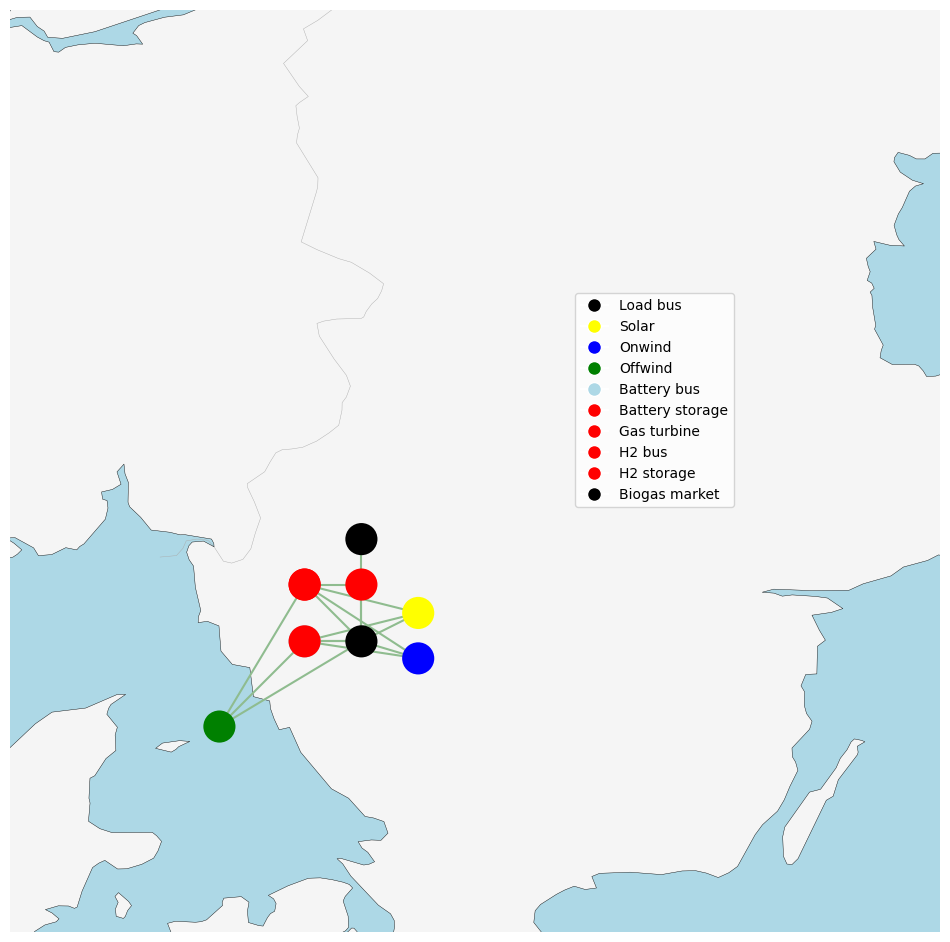

In [25]:
bus_colors = ["black", "yellow", "blue", "green", "lightblue", "red", "red", "red", "red", "black"]

minx, miny, maxx, maxy = SELECTION.total_bounds
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy.mpl.feature_artist")
network_map = widgets.Output()
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
NETWORK.plot(ax=ax, boundaries = [minx-1, maxx+3, miny-1.5, maxy+4.5], color_geomap=True, bus_sizes=0.02, bus_colors=bus_colors)
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=bus, 
                        markerfacecolor=color, markersize=10) for bus, color in zip(network.buses.index, bus_colors)]
plt.legend(handles=legend_labels, loc='upper left', bbox_to_anchor=(0.6, 0.7), ncol=1)


<Axes: title={'center': 'Energy stored'}, xlabel='snapshot'>

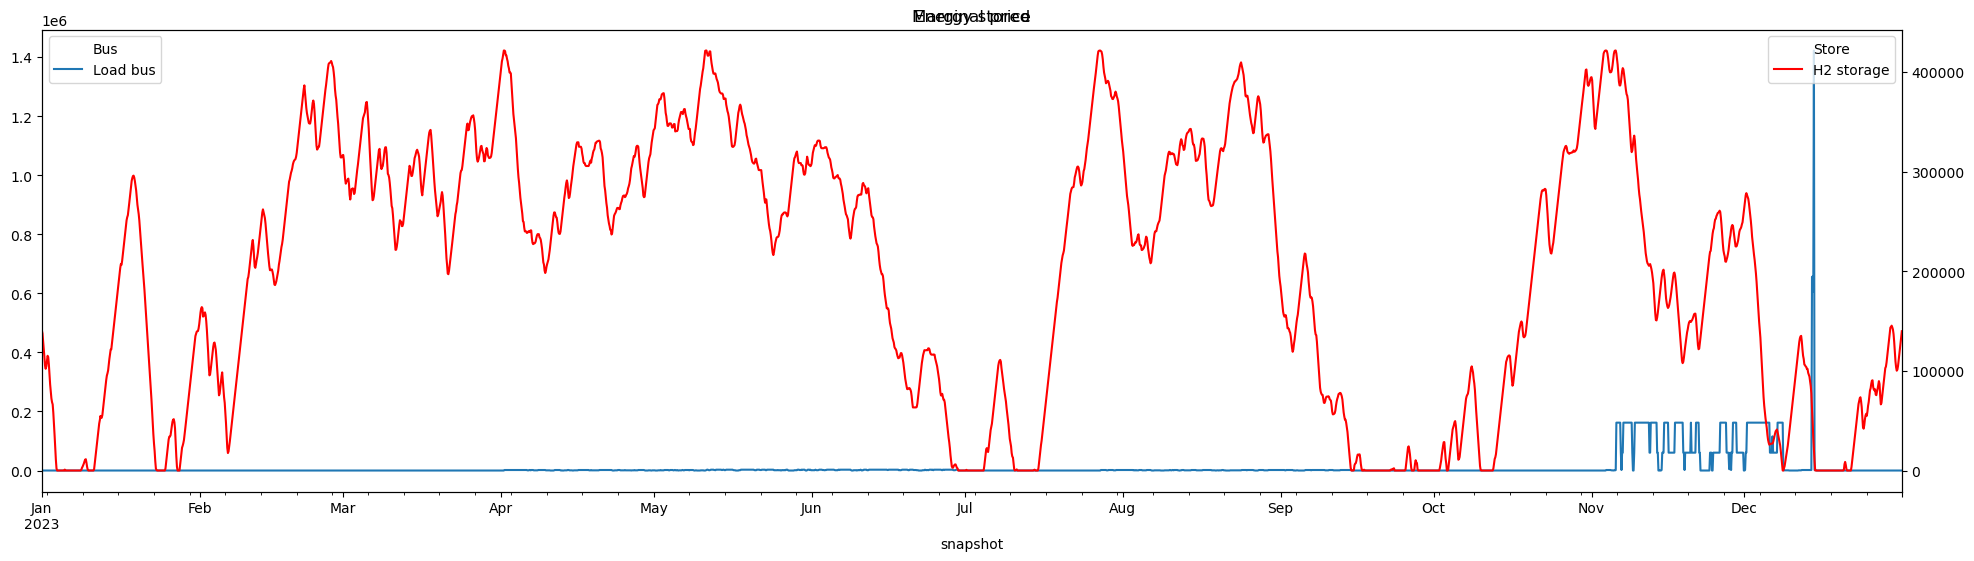

In [ ]:
fix, ax1 = plt.subplots(figsize=(24, 6))
                        
NETWORK.buses_t.marginal_price[['Load bus']].plot(ax=ax1, legend=True, title='Marginal price')

ax2 = plt.twinx(ax1)
NETWORK.stores_t.e[['H2 storage']].plot(ax=ax2,legend=True, color='red', title='Energy stored')


<Axes: title={'center': 'Marginal price'}, xlabel='snapshot'>

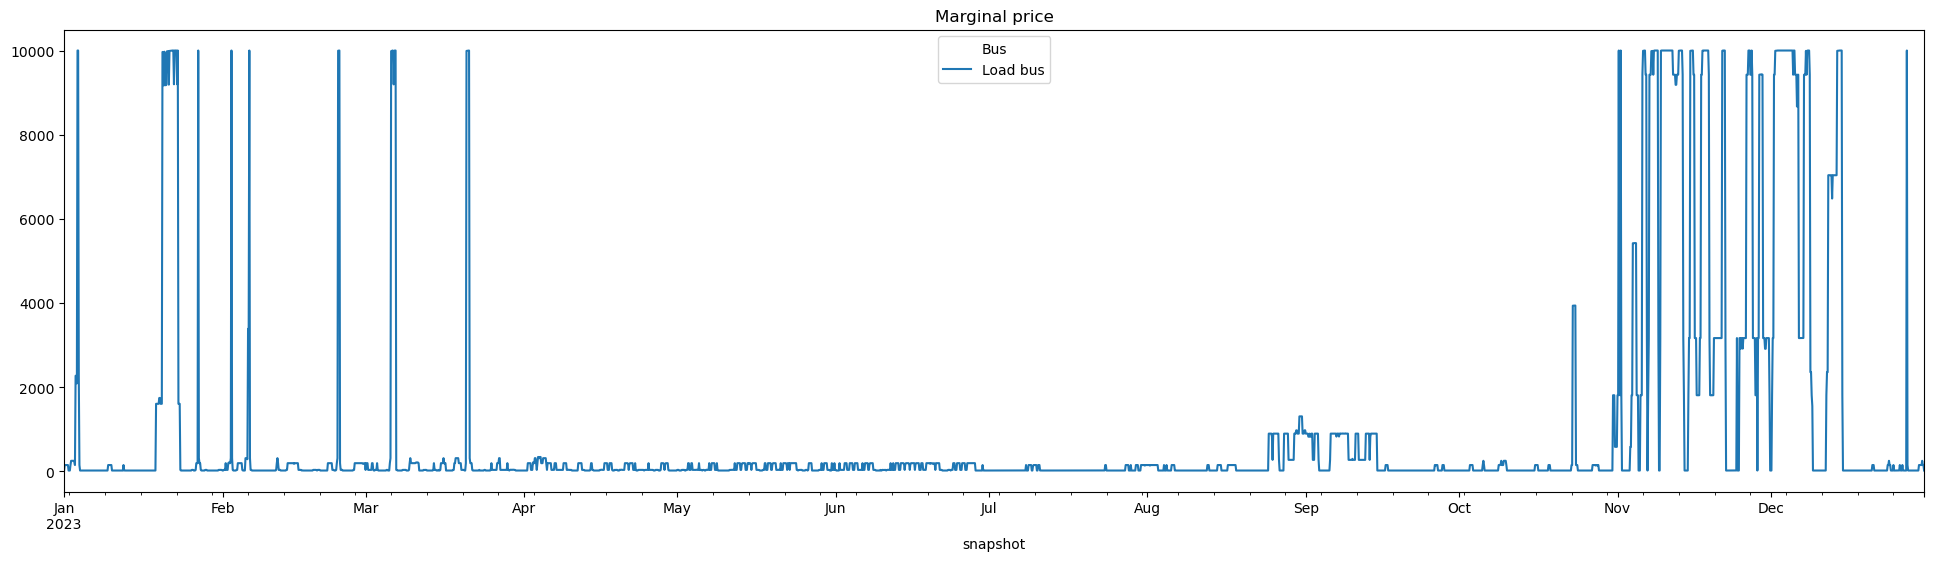

In [11]:
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')

fix, ax1 = plt.subplots(figsize=(24, 6))
                        
NETWORK.buses_t.marginal_price[['Load bus']].loc[start_date:end_date].plot(ax=ax1, legend=True, title='Marginal price')

#ax2 = plt.twinx(ax1)
#DEMAND.plot(ax=ax2, color='grey', alpha=0.2)

#NETWORK.buses_t.marginal_price.loc[start_date:end_date].mean()


In [ ]:
total_cost = NETWORK.statistics.capex().sum()
total_energy = NETWORK.generators_t.p[['Solar park', 'Onwind park', 'Offwind park', 'Biogas market']].sum().sum()

total_cost/total_energy

25373.630957190937

In [ ]:
network.statistics.capex()

component  carrier
Link       AC         5.084337e+10
           h2         0.000000e+00
           li-ion     0.000000e+00
Generator  AC         0.000000e+00
           biogas     0.000000e+00
           offwind    0.000000e+00
           onwind     1.174764e+11
           solar      3.556674e+09
Store      h2         4.215873e+10
           li-ion     3.659730e+08
dtype: float64

<Axes: xlabel='snapshot'>

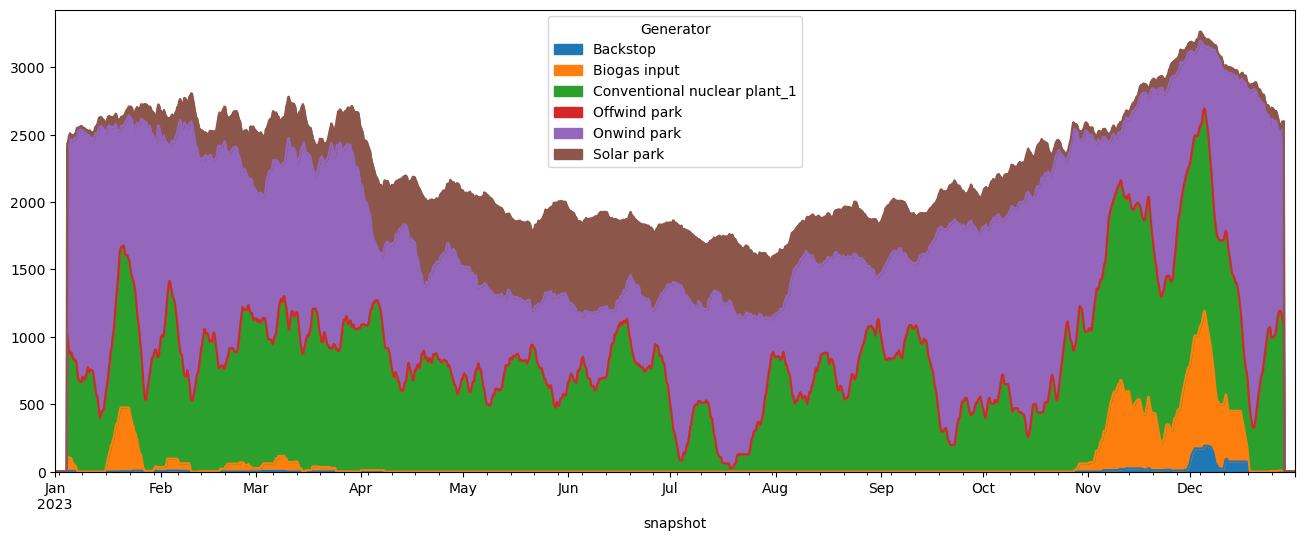

In [50]:
NETWORK.generators_t.p.abs().rolling(window=56, center=True).mean().plot(figsize=(16,6), kind='area', stacked=True)

<Axes: xlabel='snapshot'>

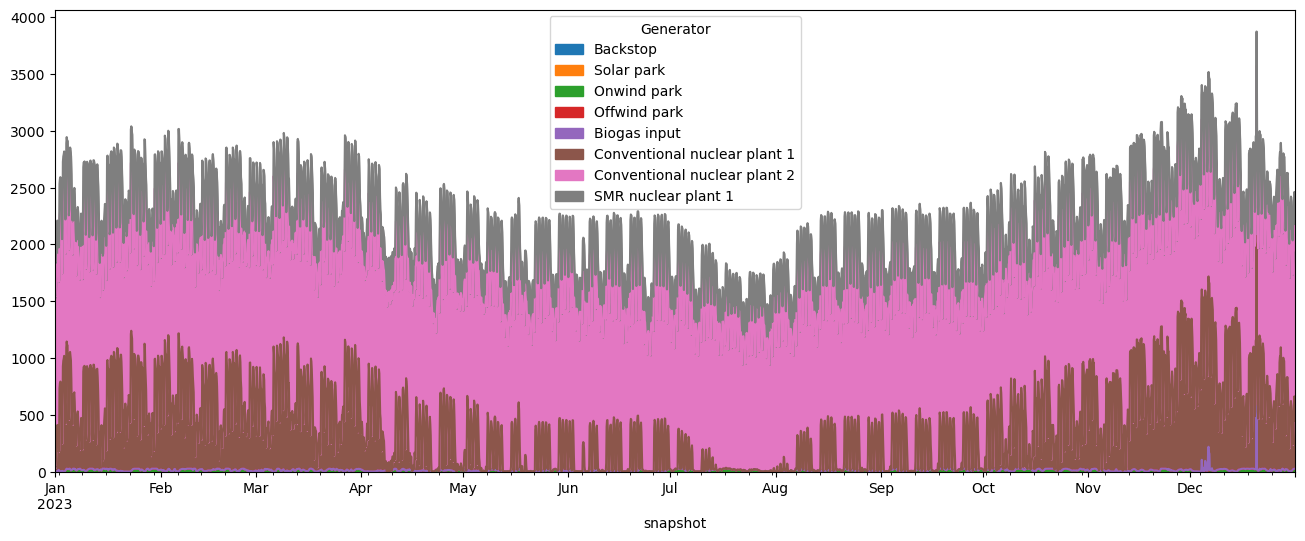

In [6]:


NETWORK.generators_t.p.abs().plot(figsize=(16,6), kind='area', stacked=True)

<Axes: xlabel='timestamp'>

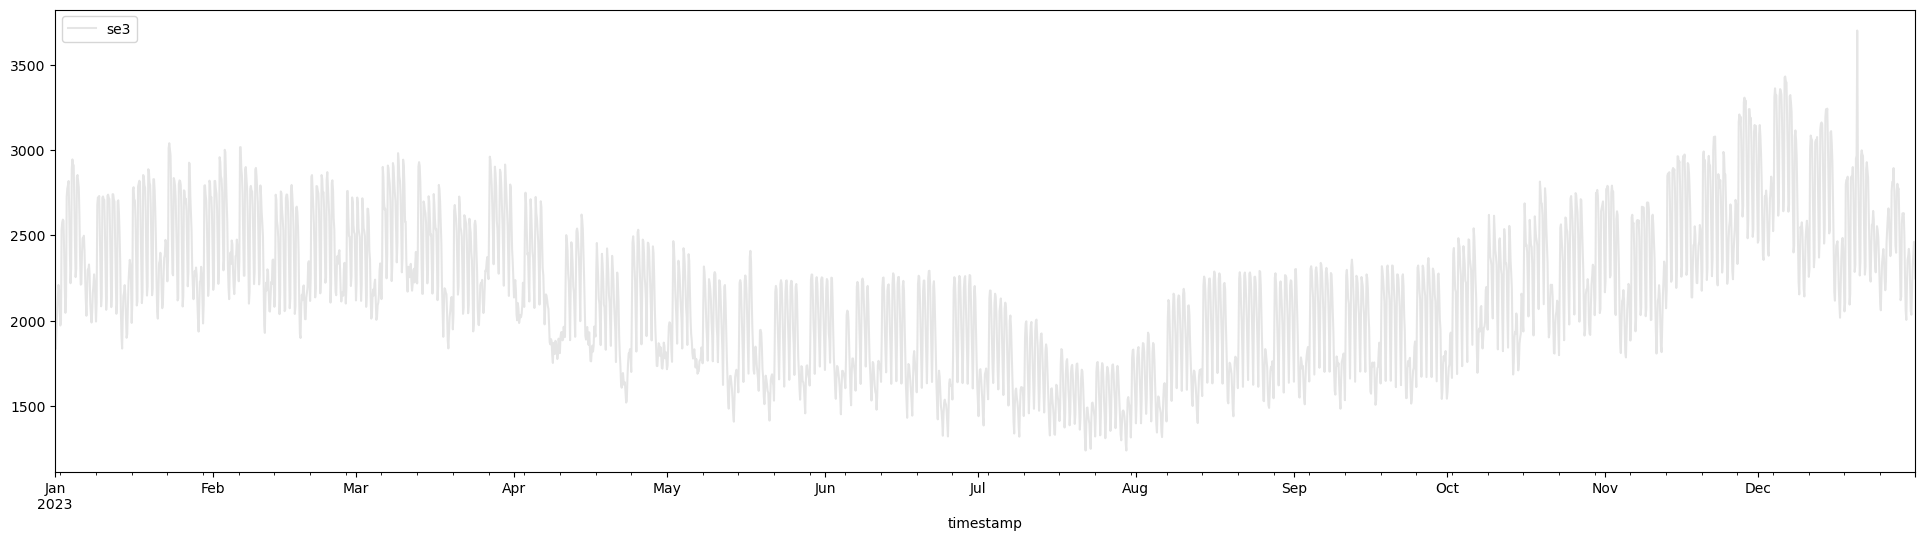

In [11]:
fix, ax1 = plt.subplots(figsize=(24, 6))                   
DEMAND.plot(ax=ax1, color='grey', alpha=0.2)

In [22]:
column_names = {
    'annual_cost': 'Årskostnad',
    'lifetime': 'Livslängd',
    'p_nom_opt': 'Kapacitet',
    'generators': 'Kraftverk',
    'energy_produced': 'Producerad energi',
}

generator_index = NETWORK.generators.index.difference(['Backstop', 'Biogas input'])

generators = pd.concat([
    NETWORK.generators.loc[NETWORK.generators.index.isin(generator_index)][['capital_cost', 'marginal_cost', 'lifetime', 'p_nom_opt', 'p_nom_mod']],
    NETWORK.links.loc[['Combined Cycle Gas turbine', 'Simple Cycle Gas turbine']][['capital_cost', 'marginal_cost', 'lifetime', 'p_nom_opt', 'p_nom_mod']]
])

generators['annual_cost'] = np.where(generators['p_nom_opt'] != 0, generators['capital_cost'] * generators['p_nom_opt'], 0)
generators['energy_produced'] = NETWORK.generators_t.p.loc[:, generator_index].sum() * 3
generators['generators'] = generators['p_nom_opt'] / generators['p_nom_mod']

other = NETWORK.links.loc[['H2 electrolysis', 'Battery charge']][['capital_cost', 'marginal_cost', 'lifetime', 'p_nom_opt']]
other['annual_cost'] = np.where(other['p_nom_opt'] != 0, other['capital_cost'] * other['p_nom_opt'], 0)

stores = NETWORK.stores.loc[["H2 storage", "Battery storage"]][['capital_cost', 'marginal_cost', 'lifetime', 'e_nom_opt']]
stores['annual_cost'] = np.where(stores['e_nom_opt'] != 0, stores['capital_cost'] * stores['e_nom_opt'], 0)
stores.rename(columns={'e_nom_opt': 'p_nom_opt'}, inplace=True)

biogas = NETWORK.generators.loc[['Biogas input']][['capital_cost', 'marginal_cost', 'lifetime', 'p_nom_opt']]
biogas['energy_produced'] = NETWORK.generators_t.p[['Biogas input']].sum() * 3 * float(parameters.loc['biogas', 'efficiency'].value)
biogas['annual_cost'] = np.where(biogas['p_nom_opt'] != 0, biogas['marginal_cost'] * biogas['energy_produced'] / float(parameters.loc['biogas', 'efficiency'].value), 0)
biogas[['lifetime', 'p_nom_opt', 'total_cost']] = 0

system = pd.concat([generators, other, stores, biogas]).drop(columns=['capital_cost', 'marginal_cost'])[['p_nom_opt', 'generators', 'lifetime', 'energy_produced', 'annual_cost']]

totals = pd.DataFrame(columns=system.columns, index=['Total'])
totals['energy_produced'] = system['energy_produced'].sum()
totals['annual_cost'] = system['annual_cost'].sum()

system = pd.concat([system, totals]).rename(columns=column_names)

years = lambda s: f'{s:,.0f} år'.replace(',', ' ')
million_cost = lambda s: f'{s/1_000_000:,.0f} MSEK'.replace(',', ' ')
energy = lambda s: f'{s/1_000:,.0f} GWh'.replace(',', ' ')
price = lambda s: f'{s:,.0f} SEK'.replace(',', ' ')
system.abs().style.format({'Livslängd': years, 'Producerad energi': energy, 'Pris': price, 'Årskostnad': million_cost, 'Totalkostnad': million_cost}, precision=0, na_rep='-')



/tmp/ipykernel_20867/3806972319.py:38: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [65]:
f"{system['Årskostnad']['Total'] / (NETWORK.loads_t.p['Desired load'].sum() * 3) / 1000 * 100:.1f} öre/kWh"

'94.5 öre/kWh'

In [16]:
170/23578

0.007210111120536093

<Axes: title={'center': 'Power output'}, xlabel='snapshot'>

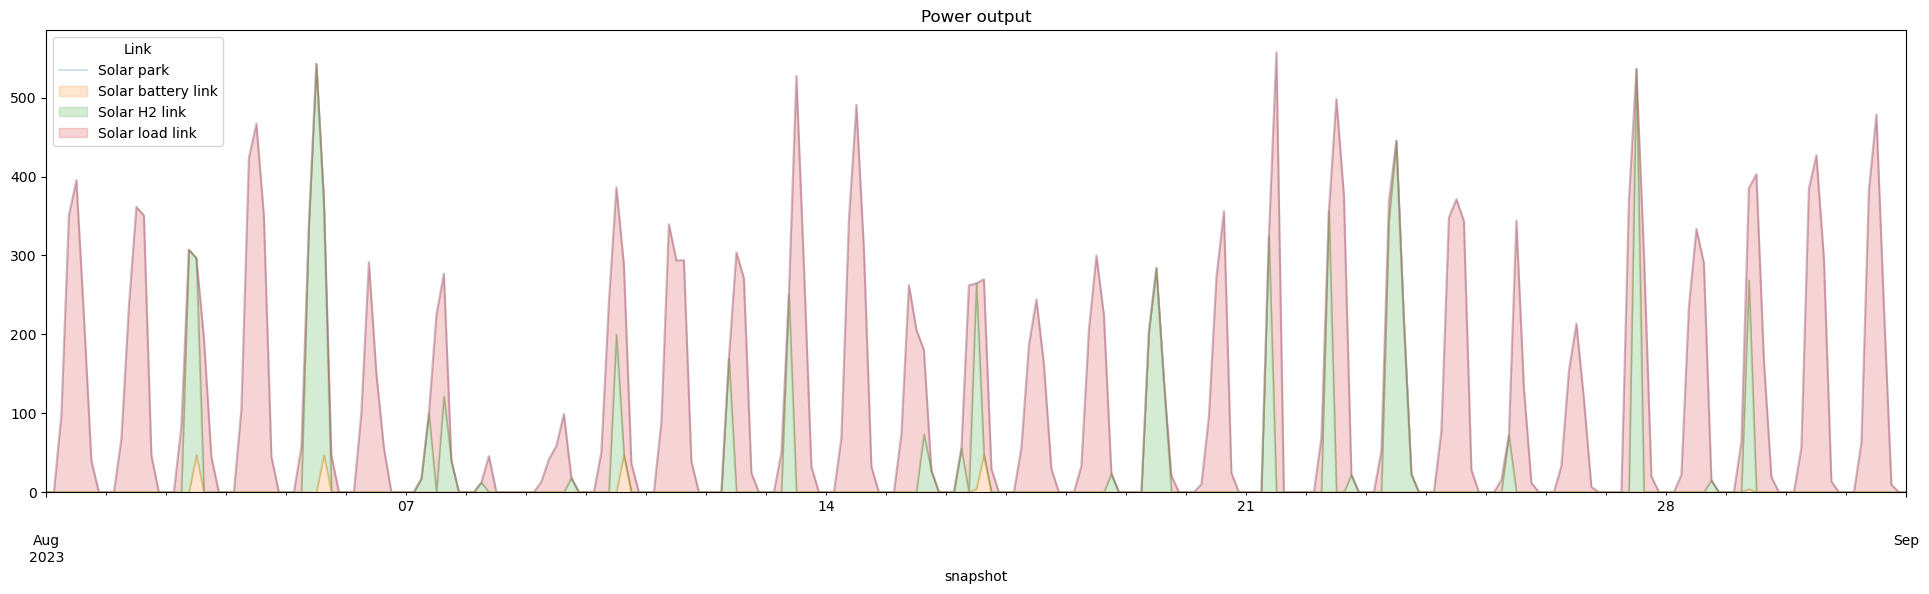

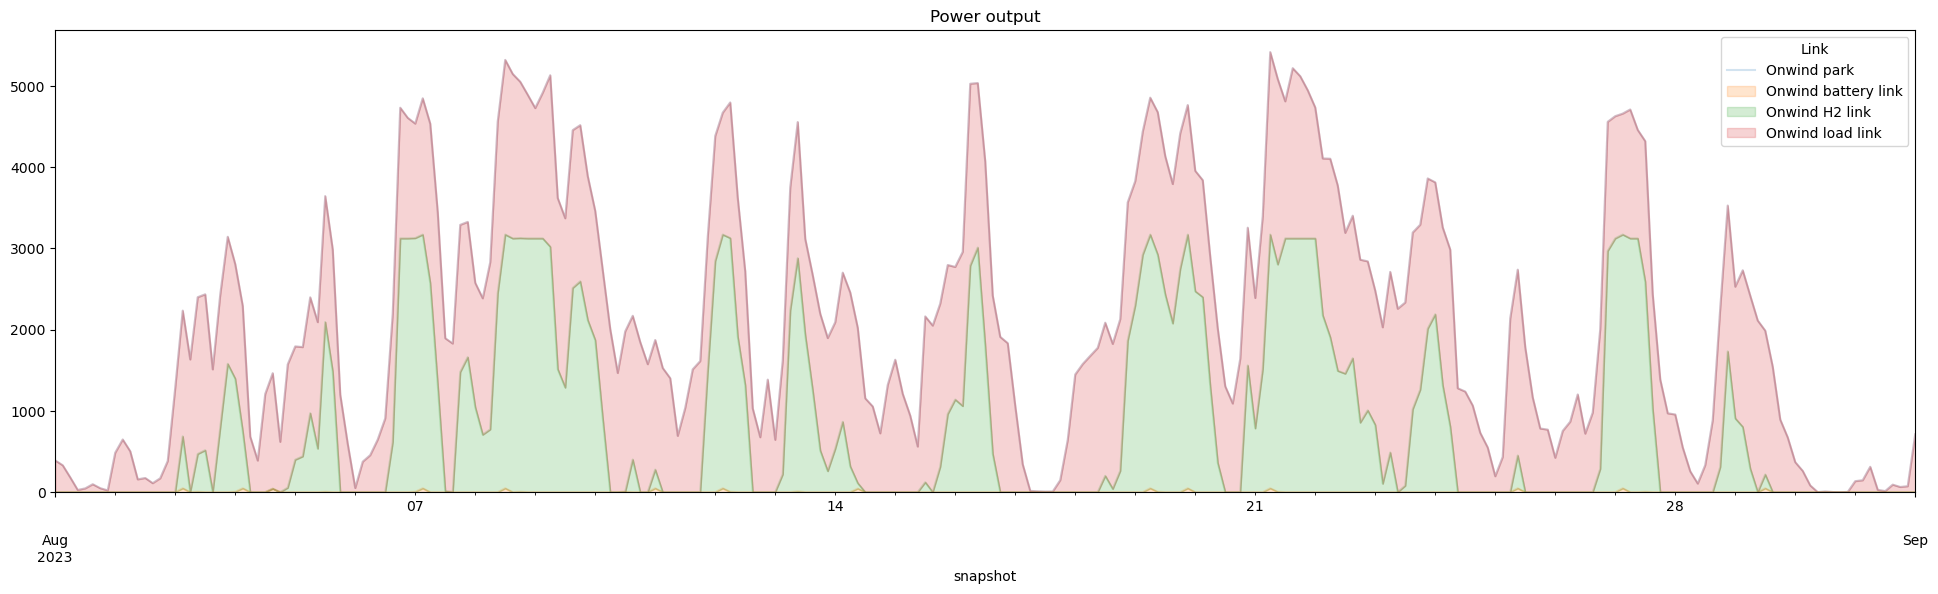

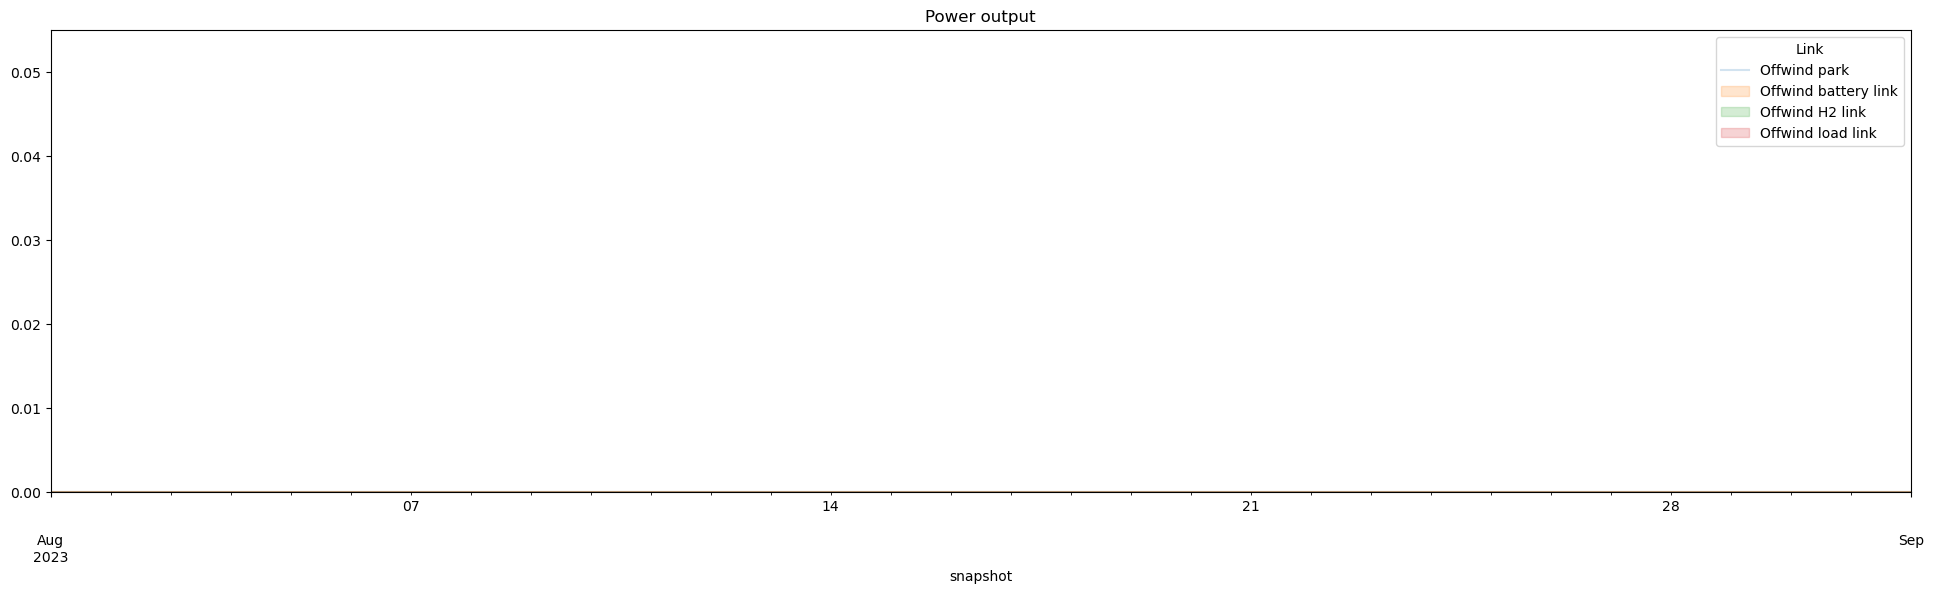

In [ ]:
start_date = pd.to_datetime('2023-08-01')
end_date = pd.to_datetime('2023-09-01')
fig1, ax1 = plt.subplots(figsize=(24, 6))
NETWORK.generators_t.p[['Solar park']].loc[start_date:end_date].plot(ax=ax1, kind='line', legend=True, alpha=0.2, title='Power output')
NETWORK.links_t.p0[['Solar battery link', 'Solar H2 link', 'Solar load link']].loc[start_date:end_date].plot(ax=ax1, kind='area', stacked=True, legend=True, alpha=0.2)

fig2, ax2 = plt.subplots(figsize=(24, 6))
NETWORK.generators_t.p[['Onwind park']].loc[start_date:end_date].plot(ax=ax2, kind='line', legend=True, alpha=0.2, title='Power output')
NETWORK.links_t.p0[['Onwind battery link', 'Onwind H2 link', 'Onwind load link']].loc[start_date:end_date].plot(ax=ax2, kind='area', stacked=True, legend=True, alpha=0.2)

fig3, ax3 = plt.subplots(figsize=(24, 6))
NETWORK.generators_t.p[['Offwind park']].loc[start_date:end_date].plot(ax=ax3, kind='line', legend=True, alpha=0.2, title='Power output')
NETWORK.links_t.p0[['Offwind battery link', 'Offwind H2 link', 'Offwind load link']].loc[start_date:end_date].plot(ax=ax3, kind='area', stacked=True, legend=True, alpha=0.2)

<Axes: xlabel='snapshot'>

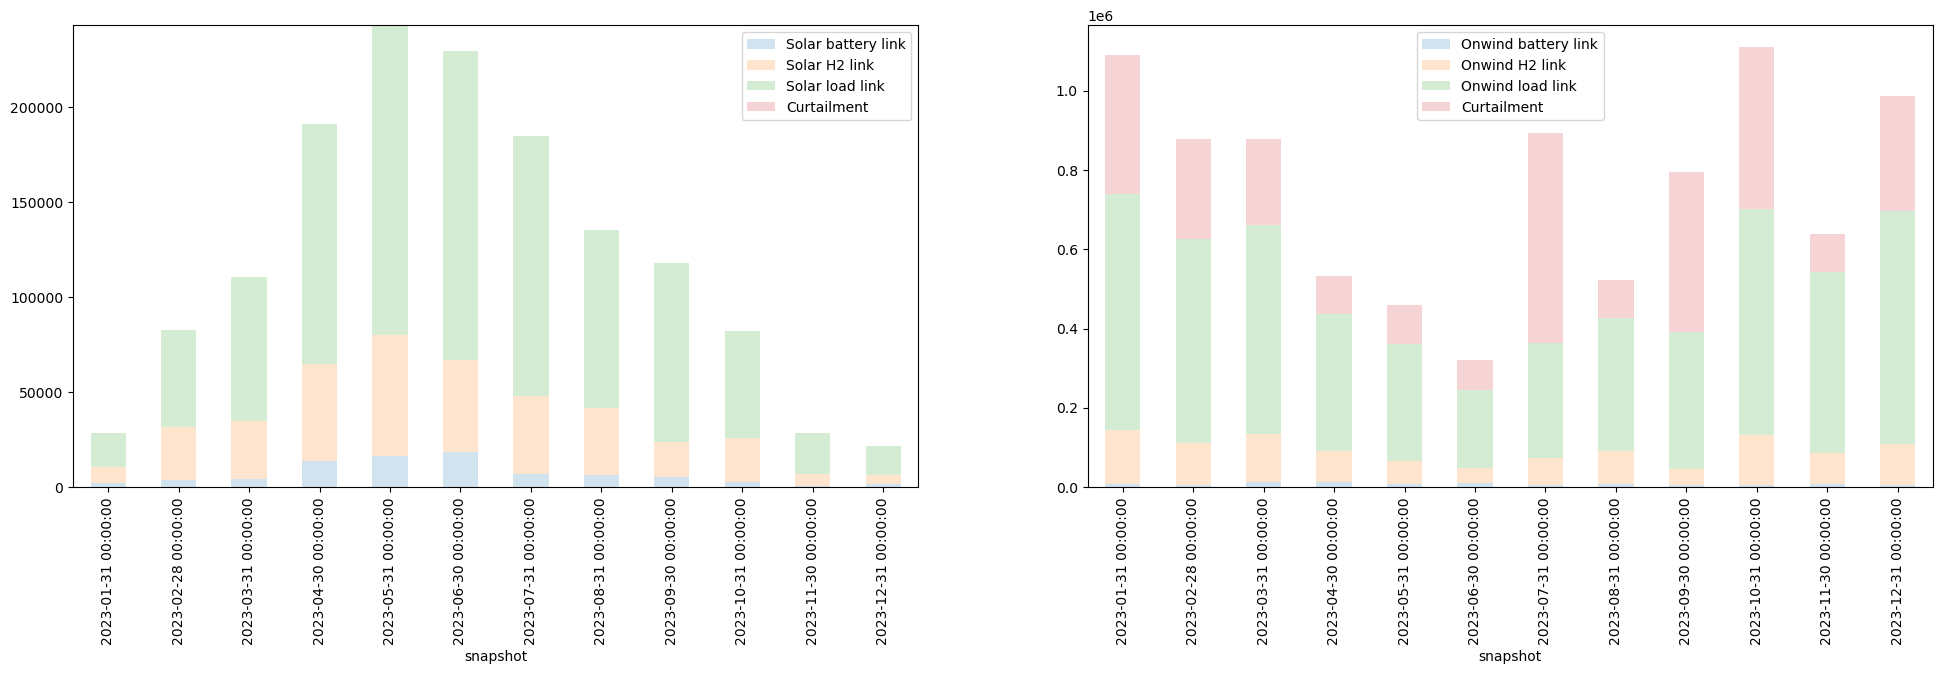

In [18]:
solar_curtailment = NETWORK.generators_t.p_max_pu[['Solar park']] * NETWORK.generators.loc['Solar park']['p_nom_opt'] - NETWORK.generators_t.p[['Solar park']]
solar_curtailment['Curtailment'] = solar_curtailment['Solar park']
solar_curtailment.drop(columns=['Solar park'], inplace=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

pd.concat([NETWORK.links_t.p0[['Solar battery link', 'Solar H2 link', 'Solar load link']], solar_curtailment]).resample('ME').sum().plot(ax=ax1, kind='bar', stacked=True, legend=True, alpha=0.2)

wind_curtailment = NETWORK.generators_t.p_max_pu[['Onwind park']] * NETWORK.generators.loc['Onwind park']['p_nom_opt'] - NETWORK.generators_t.p[['Onwind park']]
wind_curtailment['Curtailment'] = wind_curtailment['Onwind park']
wind_curtailment.drop(columns=['Onwind park'], inplace=True)

pd.concat([NETWORK.links_t.p0[['Onwind battery link', 'Onwind H2 link', 'Onwind load link']], wind_curtailment]).resample('ME').sum().plot(ax=ax2, kind='bar', stacked=True, legend=True, alpha=0.2)

In [19]:
data = pd.concat([NETWORK.links_t.p0[['Solar battery link', 'Solar H2 link', 'Solar load link']], solar_curtailment]).resample('ME').sum()

# Prepare data for Plotly
data = data.reset_index()

# Create an interactive bar chart using Plotly
fig = go.Figure()

for column in data.columns[1:]:  # Skip the first column as it is the index
    fig.add_trace(go.Bar(
        x=data['snapshot'],  # Use the reset index for the x-axis
        y=data[column],
        name=column
    ))

# Update layout for better visualization
fig.update_layout(
    barmode='stack',
    xaxis_title='Date',
    yaxis_title='Energy (MWh)',
    title='Monthly Energy Flows and Curtailment',
    legend_title='Components',
    xaxis=dict(tickformat="%Y-%m"),
    hovermode='x unified'
)

# Show the interactive chart
fig.show()

<Axes: xlabel='snapshot'>

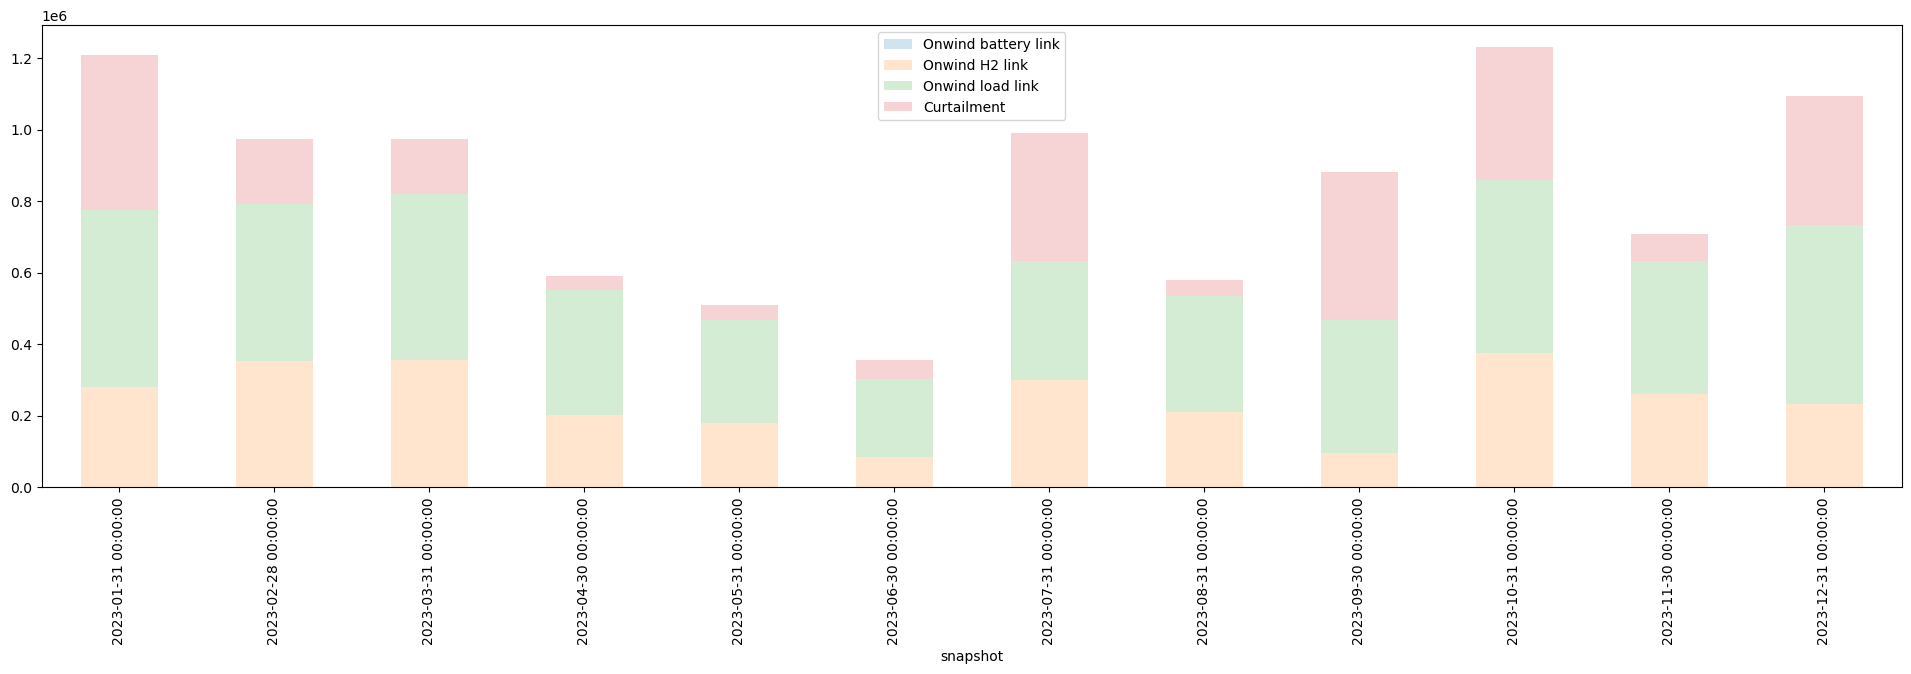

In [ ]:
data = pd.concat([NETWORK.links_t.p0[['Solar battery link', 'Solar H2 link', 'Solar load link']], solar_curtailment]).resample('ME').sum()

# Prepare data for Plotly
data = data.reset_index()

# Create an interactive bar chart using Plotly
fig = go.Figure()

for column in data.columns[1:]:  # Skip the first column as it is the index
    fig.add_trace(go.Bar(
        x=data['snapshot'],  # Use the reset index for the x-axis
        y=data[column],
        name=column
    ))

# Update layout for better visualization
fig.update_layout(
    barmode='stack',
    xaxis_title='Date',
    yaxis_title='Energy (MWh)',
    title='Monthly Energy Flows and Curtailment',
    legend_title='Components',
    xaxis=dict(tickformat="%Y-%m"),
    hovermode='x unified'
)

# Show the interactive chart
fig.show()

curtailment = NETWORK.generators_t.p_max_pu[['Onwind park']] * NETWORK.generators.loc['Onwind park']['p_nom_opt'] - NETWORK.generators_t.p[['Onwind park']]
curtailment['Curtailment'] = curtailment['Onwind park']
curtailment.drop(columns=['Onwind park'], inplace=True)

fig1, ax1 = plt.subplots(figsize=(24, 6))
pd.concat([NETWORK.links_t.p0[['Onwind battery link', 'Onwind H2 link', 'Onwind load link']], curtailment]).resample('ME').sum().plot(ax=ax1, kind='bar', stacked=True, legend=True, alpha=0.2)

In [ ]:
NETWORK.loads_t.p[['Desired load']].sum()*3

Load
Desired load    19000000.0
dtype: float64

<Axes: xlabel='snapshot'>

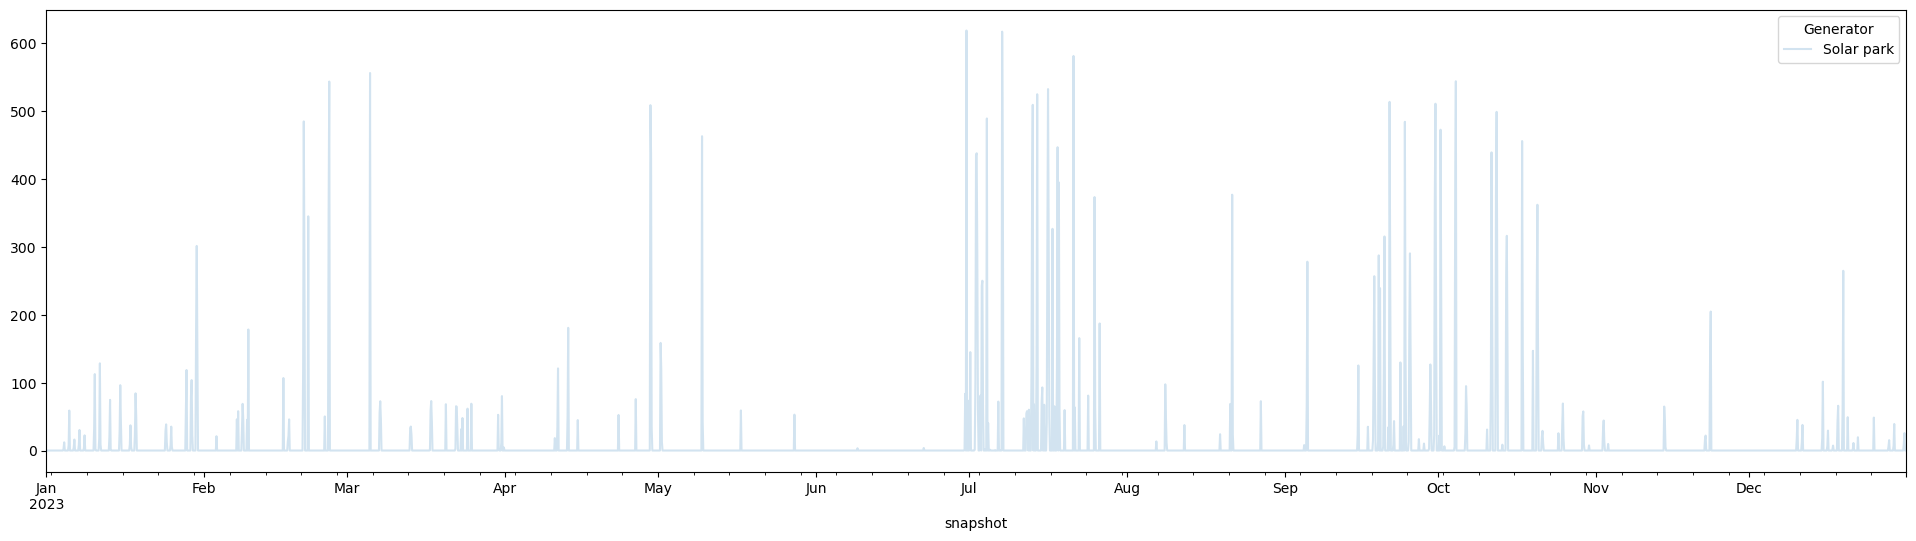

In [ ]:
curtailment = NETWORK.generators_t.p_max_pu[['Solar park']] * NETWORK.generators.loc['Solar park']['p_nom_opt'] - NETWORK.generators_t.p[['Solar park']]

curtailment.plot(figsize=(24, 6), alpha=0.2)


<Axes: title={'center': 'Power output'}, xlabel='snapshot'>

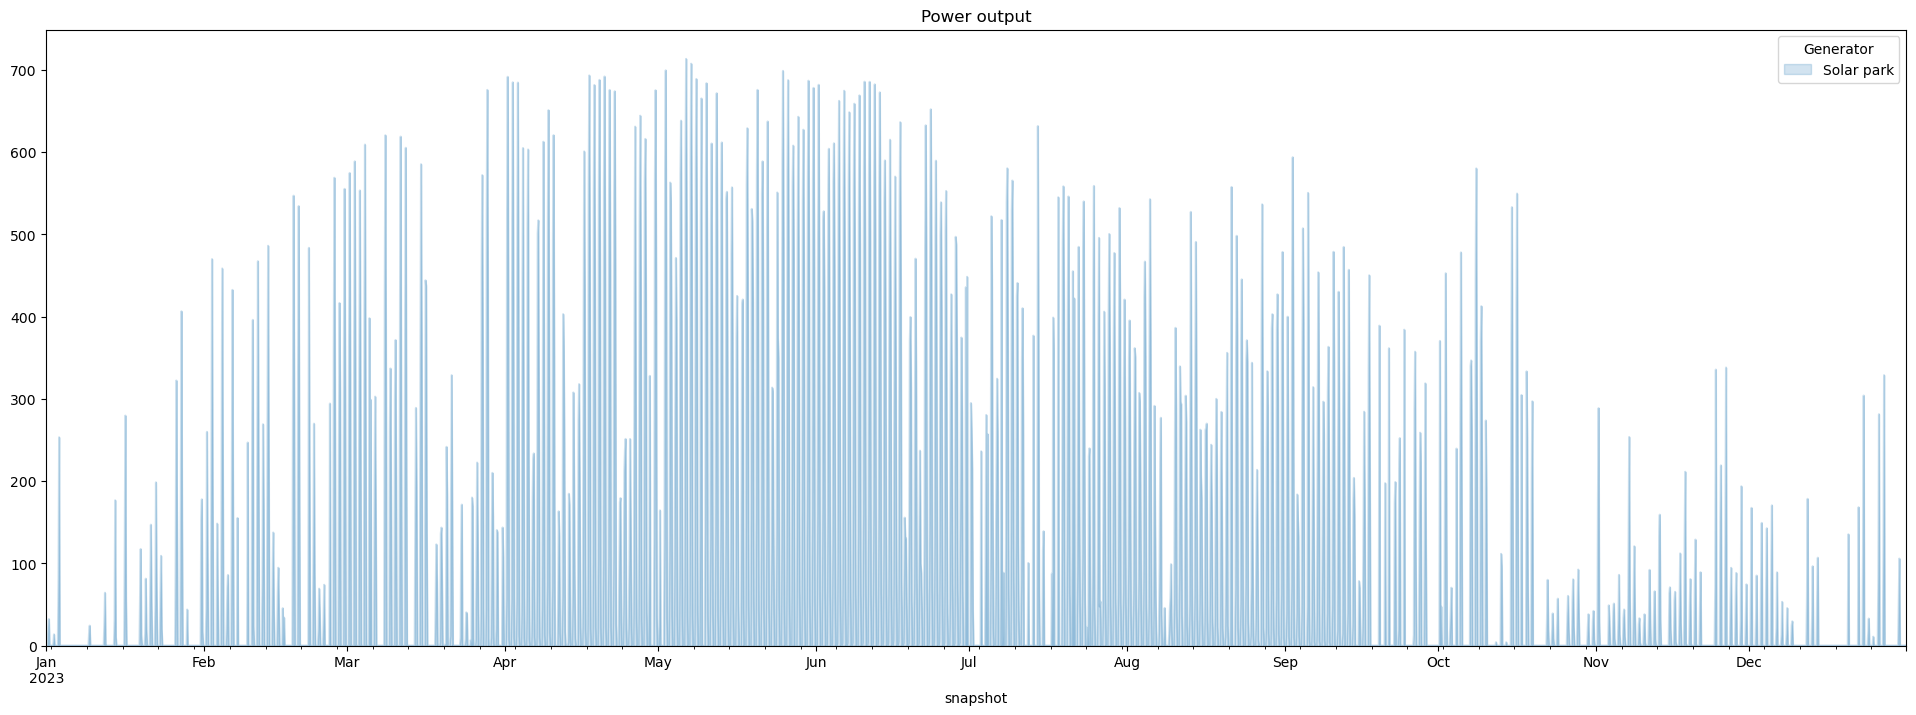

In [14]:
fig, ax = plt.subplots(figsize=(24,8))
network.generators_t.p[['Solar park']].abs().plot(ax=ax, kind='area', stacked=True, legend=True, alpha=0.2, title='Power output')
#network.generators_t.p.abs().rolling(window=window_size, center=True).mean().plot(ax=ax, kind='area', stacked=True)

<Axes: title={'center': 'Power output'}, xlabel='snapshot'>

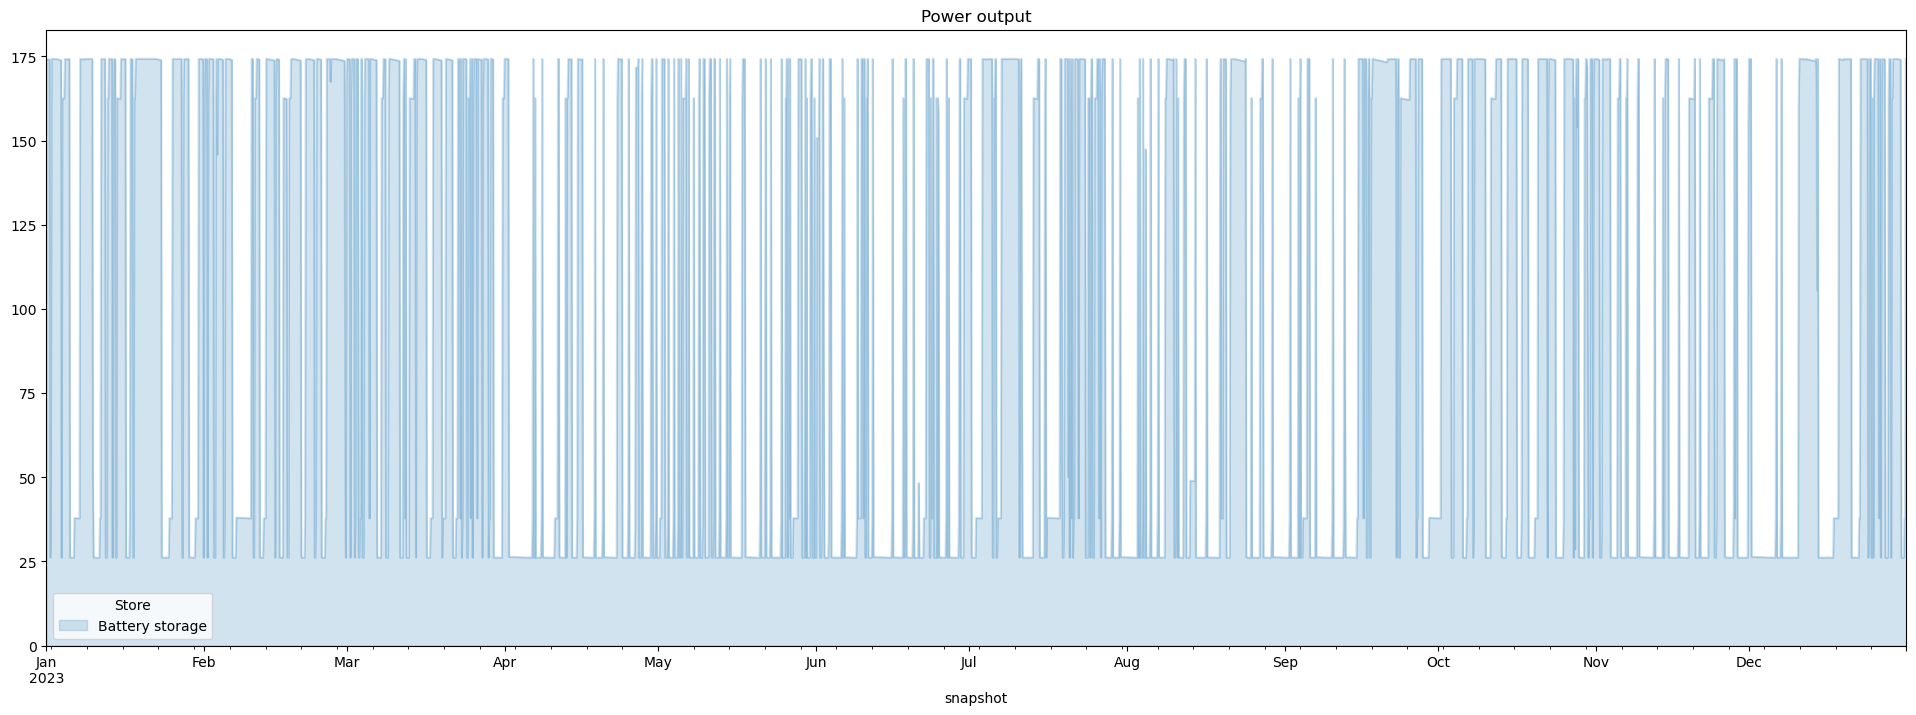

In [16]:
fig, ax = plt.subplots(figsize=(24,8))
network.stores_t.e[['Battery storage']].abs().plot(ax=ax, kind='area', stacked=True, legend=True, alpha=0.2, title='Power output')

In [22]:
NETWORK.objective

216213940774.77585